In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import re
import warnings
warnings.filterwarnings('ignore')

print("Версія TensorFlow:", tf.__version__)

Версія TensorFlow: 2.19.0


In [54]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [55]:
fake_path = "/content/drive/MyDrive/Colab/datasets/Fake.csv"
true_path = "/content/drive/MyDrive/Colab/datasets/True.csv"

fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

In [56]:
fake_df['label'] = 0
true_df['label'] = 1

df = pd.concat([fake_df, true_df], ignore_index=True)

print(f"Загальна кількість новин: {len(df)}")
print(f"Фейкових новин: {len(fake_df)}")
print(f"Справжніх новин: {len(true_df)}")
print("\nПриклад даних:")
df.head()

Загальна кількість новин: 44898
Фейкових новин: 23481
Справжніх новин: 21417

Приклад даних:


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [57]:
print("\nКолонки в датасеті:", df.columns.tolist())
print("\nПерші 3 рядки:")
df[['title', 'subject', 'date', 'label']].head(3)


Колонки в датасеті: ['title', 'text', 'subject', 'date', 'label']

Перші 3 рядки:


,title,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017"


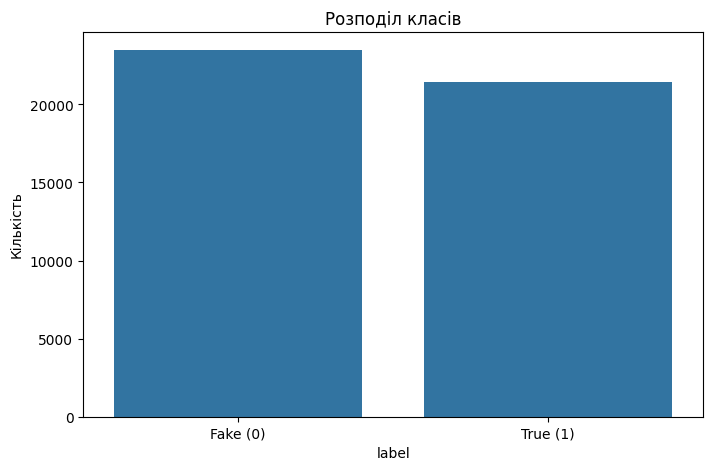

In [58]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label')
plt.title('Розподіл класів')
plt.xticks([0, 1], ['Fake (0)', 'True (1)'])
plt.ylabel('Кількість')
plt.show()

In [59]:
def preprocess_text(text):
    """Функція для очищення та обробки тексту"""
    if pd.isna(text):
        return ""

    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    words = text.split()

    return ' '.join(words)

In [60]:
df['content'] = df['title'] + ' ' + df['text']

print("Приклад оригінального тексту:")
print(df['content'].iloc[0][:300])

Приклад оригінального тексту:
 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had j


In [61]:
print("Обробка тексту...")
df['cleaned_content'] = df['content'].apply(preprocess_text)

print(f"Кількість записів: {len(df)}")
print("\nПриклад обробленого тексту:")
print(df['cleaned_content'].iloc[0][:200])

Обробка тексту...
Кількість записів: 44898

Приклад обробленого тексту:
donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to h


In [74]:
MAX_WORDS = 10000  # Максимальна кількість слів у словнику
MAX_SEQUENCE_LENGTH = 200  # Максимальна довжина послідовності
EMBEDDING_DIM = 64  # Розмірність embedding шару

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_content'])

sequences = tokenizer.texts_to_sequences(df['cleaned_content'])

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = df['label'].values

print(f"Форма X: {X.shape}")
print(f"Форма y: {y.shape}")
print(f"Розмір словника: {len(tokenizer.word_index)}")

Форма X: (44898, 200)
Форма y: (44898,)
Розмір словника: 205959


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Тренувальний набір: {X_train.shape}")
print(f"Тестовий набір: {X_test.shape}")

Тренувальний набір: (35918, 200)
Тестовий набір: (8980, 200)


In [75]:
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [76]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

In [78]:
BATCH_SIZE = 128
EPOCHS = 5

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 134s 529ms/step - accuracy: 0.8431 - loss: 0.4247 - val_accuracy: 0.8909 - val_loss: 0.3036
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 124s 459ms/step - accuracy: 0.8838 - loss: 0.3463 - val_accuracy: 0.8719 - val_loss: 0.2485
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 141s 456ms/step - accuracy: 0.8046 - loss: 0.4088 - val_accuracy: 0.9318 - val_loss: 0.2435
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 144s 463ms/step - accuracy: 0.9038 - loss: 0.3030 - val_accuracy: 0.7556 - val_loss: 0.4455
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 117s 463ms/step - accuracy: 0.8648 - loss: 0.3374 - val_accuracy: 0.9101 - val_loss: 0.2310
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 118s 467ms/step - accuracy: 0.9206 - loss: 0.2379 - val_accuracy: 0.9555 - val_loss: 0.1451
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 116s 461ms/step - accuracy: 0.8962 - loss: 0.2791 - val_accuracy: 0.8196 - val_loss: 0.3609
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 114s 452ms/step - accuracy: 0.8554 -

In [79]:
print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 200, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 200, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,065,413 (4.06 MB)

 Trainable params: 355,137 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 710,276 (2.71 MB)

None


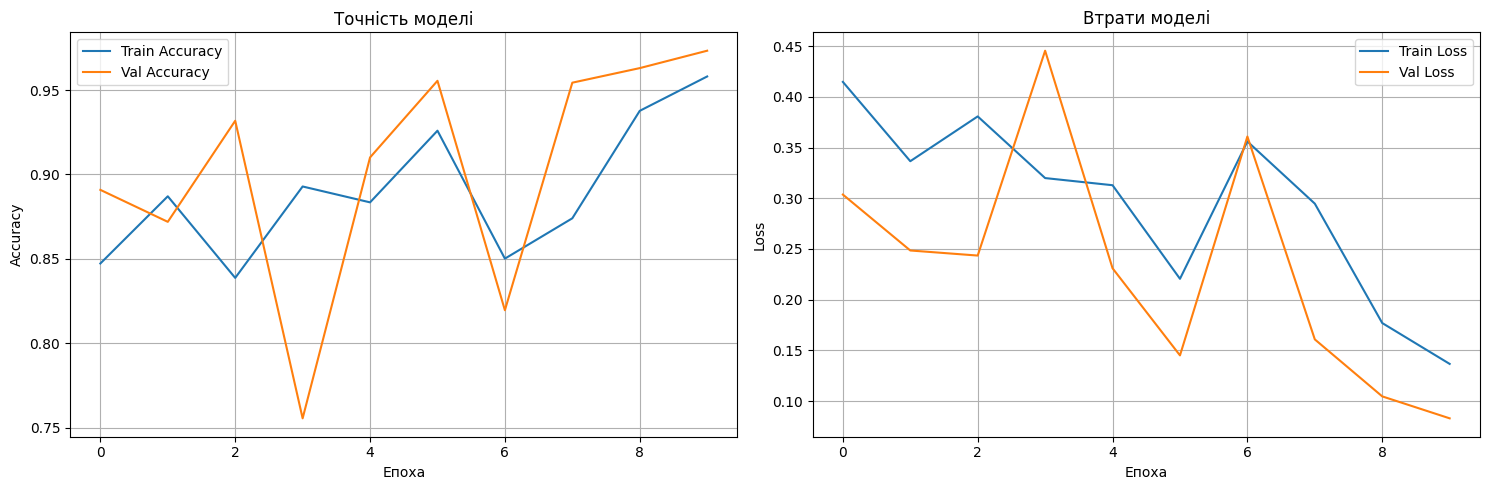

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Точність моделі')
axes[0].set_xlabel('Епоха')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Втрати моделі')
axes[1].set_xlabel('Епоха')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [81]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))

281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step
Точність на тестовому наборі: 0.9757

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98      4696
        True       0.96      0.99      0.97      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



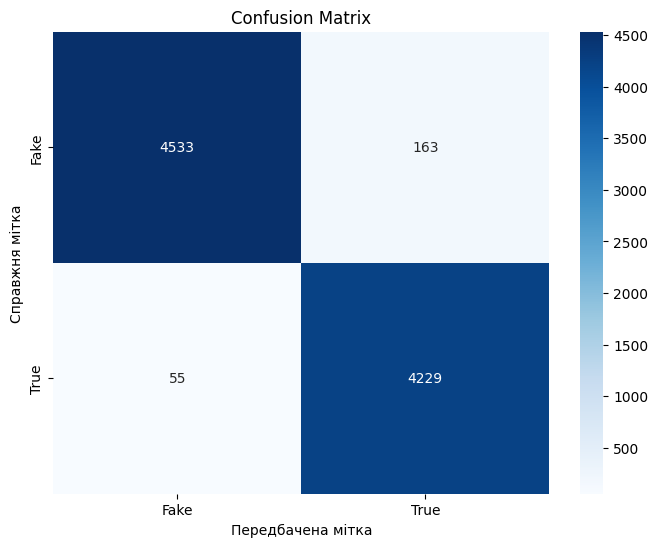

In [82]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'],
            yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix')
plt.ylabel('Справжня мітка')
plt.xlabel('Передбачена мітка')
plt.show()

In [83]:
def predict_news(text):
    """Функція для передбачення на новому тексті"""
    cleaned = preprocess_text(text)

    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    prediction = model.predict(padded)[0][0]

    if prediction > 0.5:
        return f"СПРАВЖНЯ новина (впевненість: {prediction:.2%})"
    else:
        return f"ФЕЙКОВА новина (впевненість: {(1-prediction):.2%})"

test_text = "Breaking news: Scientists discover new planet in solar system"
print(f"Текст: {test_text}")
print(f"Результат: {predict_news(test_text)}")

Текст: Breaking news: Scientists discover new planet in solar system
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Результат: ФЕЙКОВА новина (впевненість: 97.60%)


In [84]:
print("Тестування на випадкових прикладах:\n")
for i in range(5):
    idx = np.random.randint(0, len(df))
    text = df.iloc[idx]['content'][:200]
    actual = "Справжня" if df.iloc[idx]['label'] == 1 else "Фейкова"

    print(f"Приклад {i+1}:")
    print(f"Текст: {text}...")
    print(f"Справжня мітка: {actual}")
    print(f"Передбачення: {predict_news(df.iloc[idx]['content'])}")
    print("-" * 80 + "\n")

Тестування на випадкових прикладах:

Приклад 1:
Текст: Vote ruling by chief justice surprises Kenyans, but not his colleagues NAIROBI (Reuters) - Kenya s Supreme Court ruling to scrap last month s presidential election was shaped by a new chief justice wh...
Справжня мітка: Справжня
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Передбачення: СПРАВЖНЯ новина (впевненість: 95.51%)
--------------------------------------------------------------------------------

Приклад 2:
Текст:  WATCH: Rachel Maddow Has PERFECT Argument To Prove Trump Is A Failure Despite His Bragging Donald Trump can brag all he wants, but Rachel Maddow knows that Trump s presidency has been nothing but a d...
Справжня мітка: Фейкова
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Передбачення: ФЕЙКОВА новина (впевненість: 99.28%)
--------------------------------------------------------------------------------

Приклад 3:
Текст: How Trump crushed naysayers with a coalition of the forgotten WASHINGTON (Reuters) - Donald Trump was right. 